### Import libraries

In [1]:
import pandas as pd 
import numpy as np
import sys
import re
import requests
import scipy.stats
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
import nltk
from rake_nltk import Rake
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv("jobs.csv")

In [3]:
data.shape

(4291, 8)

### Drop duplicates

In [4]:
duplicates = data[data.duplicated(keep=False)]

In [5]:
duplicates.shape

(1846, 8)

In [6]:
df = data.drop_duplicates(keep='first').reset_index(drop=True)

In [7]:
df.shape

(3175, 8)

In [8]:
df = df.apply(lambda x: x.replace('', np.NaN))

In [9]:
df.isna().sum()

title          0
company        0
location       0
salary         0
type           0
remote         0
description    0
link           0
dtype: int64

In [10]:
df.head()

,title,company,location,salary,type,remote,description,link
0,Data Analyst,e.surv Chartered Surveyors,Kettering\r\n Northamptonshire,Salary negotiable,"Permanent, full-time",Work from home,"Trading since 1989, e.surv Chartered Surveyors...",https://www.reed.co.uk/jobs/data-analyst/49988...
1,Data Analyst,University of the West of Scotland,Paisley\r\n Renfrewshire,"£32,000 - £39,000 per annum","Contract, full-time",Not specified,"Registry Full time, Fixed-term for 24 months T...",https://www.reed.co.uk/jobs/data-analyst/50197...
2,Data Analyst,Brandon James Ltd,Bristol\r\n Avon,"£40,000 - £45,000 per annum","Contract, full-time",Not specified,A strategic medium sized consultancy is now se...,https://www.reed.co.uk/jobs/data-analyst/50020...
3,Data Analyst,Brandon James Ltd,London\r\n London,"£40,000 - £45,000 per annum","Contract, full-time",Not specified,A strategic medium sized consultancy is now se...,https://www.reed.co.uk/jobs/data-analyst/50020...
4,Data Analyst,The Consultancy Group,London\r\n London,"£35,000 - £50,000 per annum","Permanent, full-time",Not specified,I am partnered with a renowned Retail business...,https://www.reed.co.uk/jobs/data-analyst/50188...


# Cleaning

In [11]:
df.dtypes

title          object
company        object
location       object
salary         object
type           object
remote         object
description    object
link           object
dtype: object

#### Drop unwanted columns(Clean title)

In [12]:
# clean title column - check for non data job titles and drop

mask = ~df['title'].str.lower().str.contains('data|bi|powerbi|machine|python|tableau|sql|operations|business|machinelearning|performance|analytics|analytic|bi|anayst|insights|insight|analysis|digital|anlayst|visualisation|database|model|researcher|mlops', case=False)
df.drop(index=df[mask].index, inplace=True)

In [13]:
df.shape

(1442, 8)

In [16]:
# rename rows

df.loc[2974, 'title'] = 'Data Developer' #df[df['title']=='Data/Software developer - Bristol - £45,000']
df.loc[1204, 'title'] = 'IT Business Analyst' #df[df['title']=='it Business systems analyst - Fully remote - £60K']
df.loc[1204, 'remote'] = 'Work from home'

In [17]:
# drop duplicates and non data titles

df.drop(df[df['title']=='Data/Software developer - Bristol - £45,000'].index, inplace=True)
df.drop(df[df['title']=='it Business systems analyst - Fully remote - £60K'].index, inplace=True)
df.drop(df[df['title']=='IT Business Systems Analyst - Remote - Up to £60k'].index, inplace=True)
df.drop(df[df['title']=='Dynamics 365 Analyst/ Application Analyst D365'].index, inplace=True)
df.drop(df[df['title']=='Cyber Security Analyst - Hybrid - Inside IR35'].index, inplace=True)
df.drop(df[df['company']=='Red Sky Personnel Ltd'].index, inplace=True)
df.drop(df[df['title']=='Lead Credit Risk Modeller IRB - 4 day working week'].index, inplace=True)
df.drop(df[df['title']=='IRB / IFRS / Lead Credit Risk Modeller - 4 day working week'].index, inplace=True)
df.drop(df[df['title']=='Junior Finance Business Partner'].index, inplace=True)
df.drop(df[df['title']=='Microbiology Graduate Laboratory Technician'].index, inplace=True)
df.drop(df[df['title']=='Graduate Microbiologist'].index, inplace=True)
df.drop(df[df['title']=='Lead Cyber Security Operations Analyst'].index, inplace=True)

#### Clean status

In [18]:
df['type'].unique()

array(['Permanent, full-time', 'Contract, full-time',
       'Temporary, full-time', 'Permanent, full-time or part-time',
       'Contract, part-time', 'Permanent, part-time',
       'Contract, full-time or part-time'], dtype=object)

In [19]:
# clean status
df['status1'] = df['type'].apply(lambda x:x.split(",")[0])
df['status2'] = df['type'].apply(lambda x:x.split(",")[1])

#### Clean location

In [20]:
# clean location
def clean_loc(s):
    S = str(s)
    S = re.sub(r'\r\n', ';', S)
    S = re.sub(r'[^a-zA-Z;]+', ' ', S).strip()
    return S

# apply function and split locations
df['city'] = df['location'].apply(clean_loc).apply(lambda x:x.split(";")[0])
df['region'] = df['location'].apply(clean_loc).apply(lambda x: x.split(";")[1] if len(x)>1 and len(x.split(";"))>1 else x)

#### Clean remote jobs

In [21]:
# clean remote jobs
df['remote'] = np.where(df['remote'].isin(['Work from home']), 'yes', 'no')

#### Clean salary

In [22]:
# extract salary type
def cleansaltype(row):
    if 'annum' in row['salary']:
        return 'annual'
    elif 'day' in row['salary']:
        return 'daily'
    elif 'hour' in row['salary']:
        return 'hourly'
    else:
        return 'unknown'

# extract salary amount
def cleannum(s):
    S = str(s)
    S = re.findall("[0-9,.]+", S)
    return S

# apply cleaning functions
df['salary_type'] = df.apply(cleansaltype, axis=1)
df['salary_num'] = df['salary'].apply(cleannum).apply(lambda x:[value for value in x if value])

In [23]:
# split min salary and max salary to separate columns
df['salary_min'] = df['salary_num'].apply(lambda x: x[0] if len(x)>1 else x)
df['salary_max'] = df['salary_num'].apply(lambda x: x[1] if len(x)>1 else x)

In [24]:
# remove special characters
def clean_spec_char(s):
    S = str(s)
    S = re.sub(r'[^0-9.]+', '', S)
    return S

df['salary_min'] = df['salary_min'].apply(clean_spec_char)
df['salary_max'] = df['salary_max'].apply(clean_spec_char)

In [25]:
# find nans
df = df.apply(lambda x: x.replace('', np.NaN))

In [26]:
df.isna().sum()

title            0
company          0
location         0
salary           0
type             0
remote           0
description      0
link             0
status1          0
status2          0
city             0
region           0
salary_type      0
salary_num       0
salary_min     308
salary_max     317
dtype: int64

In [27]:
# fill nans with not null columns
mask = (df['salary_min'].notnull()) & (df['salary_max'].isnull())
df.loc[mask, 'salary_max'] = df.loc[mask, 'salary_min']

In [28]:
df.dtypes

title          object
company        object
location       object
salary         object
type           object
remote         object
description    object
link           object
status1        object
status2        object
city           object
region         object
salary_type    object
salary_num     object
salary_min     object
salary_max     object
dtype: object

In [29]:
# change data types
df['salary_min']=df['salary_min'].astype(float)
df['salary_max']=df['salary_max'].astype(float)

In [30]:
df['salary_type'].unique()

array(['unknown', 'annual', 'daily', 'hourly'], dtype=object)

In [31]:
# define a function to convert salary to annual
def convert_to_annual(salary, salary_type):
    if salary_type == 'annual':
        return salary
    elif salary_type == 'daily':
        return salary * 250 # assuming 250 working days in a year
    elif salary_type == 'hourly':
        return salary * 8 * 250 # assuming 8 working hours in a day and 250 working days in a year

# apply the function to create a new column with annual salaries
df['annual_salary'] = df.apply(lambda row: convert_to_annual(row['salary_max'], row['salary_type']), axis=1)

In [34]:
# edit incorrect salary
df.loc[2459, 'salary_max'] = 55000
df.loc[2459, 'annual_salary'] = 55000

#### Clean job description

In [35]:
# clean description
def clean_des(s):
    S = str(s)
    S = re.sub('[%s]' % re.escape(string.punctuation), '', S).lower() #remove punctutations
    S = re.sub(r"http\S+", "", S)
    S = re.sub(r"[^a-zA-Z]+", " ", S).strip()
    return S

def lemmatize(s):
    S = str(s)
    S = word_tokenize(S)
    lm = WordNetLemmatizer() 
    lemmatized = [lm.lemmatize(w) for w in S]
    return lemmatized

def remove_stopwords(lemmatized):
    without_sw = " ".join([word for word in lemmatized if word not in stopwords.words('english')])
    return without_sw

df['descriptionclean'] = df['description'].apply(clean_des).apply(lemmatize).apply(remove_stopwords)

In [46]:
# extract keywords
# def extract_keywords(description):
#     r = Rake()
#     r.extract_keywords_from_text(description)
#     return ' '.join(list(r.get_word_degrees().keys()))

# df['des_keywords'] = df['descriptionclean'].apply(extract_keywords)

#### Clean region

In [37]:
df['region'].unique()

array([' Northamptonshire', ' Renfrewshire', ' Avon', ' London',
       ' Ayrshire', ' Buckinghamshire', ' Lancashire', ' Hertfordshire',
       ' East Sussex', ' Somerset', ' Merseyside', ' Leicestershire',
       ' Essex', ' West Midlands County', ' South Yorkshire',
       ' Tyne and Wear', ' Dumfriesshire', ' Staffordshire', ' Suffolk',
       ' Surrey', ' Cleveland', ' Kent', ' Wiltshire', ' Cambridgeshire',
       ' Oxfordshire', ' Middlesex', ' Derbyshire', ' Lanarkshire',
       ' Norfolk', ' Hampshire', ' North Yorkshire', ' West Yorkshire',
       ' West Glamorgan', ' Cheshire', ' Nottinghamshire', ' Devon',
       ' Midlothian', ' Gwynedd', ' Shropshire', ' Worcestershire',
       ' Mid Glamorgan', ' Warwickshire', ' Dorset', 'Scotland',
       ' Berkshire', ' Gloucestershire', ' County Dublin',
       ' Bedfordshire', ' South Glamorgan', 'West Midlands Region', 'USA',
       ' West Sussex', ' Lincolnshire', ' North Humberside',
       'South West England', 'Ireland', 'South

In [38]:
# clean region
df['region'] = df['region'].str.strip()

yorkshire = ['West Yorkshire', 'South Yorkshire', 'North Yorkshire', 'South Humberside', 'North Humberside']
westmidlands = ['West Midlands County', 'West Midlands Region', 'Shropshire', 'Worcestershire', 'Warwickshire','Staffordshire']
eastofengland = ['Bedfordshire','Cambridgeshire','Essex', 'Hertfordshire', 'Norfolk','Suffolk']
eastmidlands = ['Nottinghamshire', 'Lincolnshire', 'Leicestershire', 'Derbyshire']
northeast = ['County Durham', 'Tyne and Wear', 'Cleveland']
northwest = ['Cheshire', 'Cumbria', 'Lancashire', 'Merseyside','Liverpool']
southeast = ['Hampshire','Berkshire','Buckinghamshire','East Sussex','Kent','Oxfordshire','Surrey','West Sussex','Middlesex']
southwest = ['Devon','Dorset','Gloucestershire','Somerset','Wiltshire']
scotland = ['Renfrewshire','Lanarkshire','West Lothian','Midlothian','Aberdeenshire','Stirlingshire','Ayrshire','Dumfriesshire','Scotland']
wales = ['Dyfed', 'Powys','West Glamorgan','Gwynedd','Mid Glamorgan','Gwent','Clwyd','South Glamorgan']
germany = ['Lower Saxony']
sweden = ['Stockholm']
ireland = ['County Carlow','County Armagh', 'County Antrim','Ireland','County Dublin']
malta = ['Valletta','Malta']

df['region'] = np.where(df['region'].isin(yorkshire), 'Yorkshire and Humber', df['region'])
df['region'] = np.where(df['region'].isin(westmidlands), 'West Midlands', df['region'])
df['region'] = np.where(df['region'].isin(eastofengland), 'East of England', df['region'])
df['region'] = np.where(df['region'].isin(eastmidlands), 'East Midlands', df['region'])
df['region'] = np.where(df['region'].isin(northeast), 'North East England', df['region'])
df['region'] = np.where(df['region'].isin(northwest), 'North West England', df['region'])
df['region'] = np.where(df['region'].isin(southeast), 'South East England', df['region'])
df['region'] = np.where(df['region'].isin(southwest), 'South West England', df['region'])
df['region'] = np.where(df['region'].isin(scotland), 'Scotland', df['region'])
df['region'] = np.where(df['region'].isin(wales), 'Wales', df['region'])
df['region'] = np.where(df['region'].isin(germany), 'Germany', df['region'])
df['region'] = np.where(df['region'].isin(sweden), 'Sweden', df['region'])
df['region'] = np.where(df['region'].isin(ireland), 'Ireland', df['region'])
df['region'] = np.where(df['region'].isin(malta), 'Malta', df['region'])

In [39]:
df['region'].unique()

array(['Northamptonshire', 'Scotland', 'Avon', 'London',
       'South East England', 'North West England', 'East of England',
       'South West England', 'East Midlands', 'West Midlands',
       'Yorkshire and Humber', 'North East England', 'Wales', 'Ireland',
       'USA', 'Malta', 'Gibraltar', 'Channel Islands', 'Spain', 'Germany',
       'Poland'], dtype=object)

#### Drop duplicate columns

In [41]:
df.head(2)

,title,company,location,salary,type,remote,description,link,status1,status2,city,region,salary_type,salary_num,salary_min,salary_max,annual_salary,descriptionclean
0,Data Analyst,e.surv Chartered Surveyors,Kettering\r\n Northamptonshire,Salary negotiable,"Permanent, full-time",yes,"Trading since 1989, e.surv Chartered Surveyors...",https://www.reed.co.uk/jobs/data-analyst/49988...,Permanent,full-time,Kettering,Northamptonshire,unknown,[],NaN,NaN,NaN,trading since esurv chartered surveyor uk numb...
1,Data Analyst,University of the West of Scotland,Paisley\r\n Renfrewshire,"£32,000 - £39,000 per annum","Contract, full-time",no,"Registry Full time, Fixed-term for 24 months T...",https://www.reed.co.uk/jobs/data-analyst/50197...,Contract,full-time,Paisley,Scotland,annual,"[32,000, 39,000]",32000.0,39000.0,39000.0,registry full time fixedterm month post data a...


In [42]:
datajobs = df.drop(['location', 'salary', 'type', 'description', 'link', 'salary_num'], axis=1).copy()

In [43]:
datajobs = datajobs.reset_index(drop=True)

In [44]:
datajobs.shape

(1415, 12)

In [46]:
# define the new order of columns as a list
new_column_order = ['title','company','salary_type','salary_min','salary_max','annual_salary','city','region','remote','status1','status2','descriptionclean']

# select the columns in the new order
datajobs = datajobs[new_column_order]

In [47]:
datajobs.isna().sum()

title                 0
company               0
salary_type           0
salary_min          308
salary_max          308
annual_salary       308
city                  0
region                0
remote                0
status1               0
status2               0
descriptionclean      0
dtype: int64

In [49]:
#datajobs.to_csv('jobs_cleaned.csv', index=False)

In [50]:
datajobs.head(2)

,title,company,salary_type,salary_min,salary_max,annual_salary,city,region,remote,status1,status2,descriptionclean
0,Data Analyst,e.surv Chartered Surveyors,unknown,NaN,NaN,NaN,Kettering,Northamptonshire,yes,Permanent,full-time,trading since esurv chartered surveyor uk numb...
1,Data Analyst,University of the West of Scotland,annual,32000.0,39000.0,39000.0,Paisley,Scotland,no,Contract,full-time,registry full time fixedterm month post data a...


## Top words Analysis

In [51]:
# make a corpus of all the words in the job description
corpus = " ".join(datajobs['descriptionclean'].tolist())

In [55]:
lm = WordNetLemmatizer() 

# tokenize words
tokenize_corpus = nltk.word_tokenize(corpus)

# lemmatize tokens
lemmatize_tokens = [lm.lemmatize(token) for token in tokenize_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatize_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

In [56]:
# sort list by top words
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

In [57]:
# show top 20 words
top20 = top_words[:20]
top20

[('data', 9345),
 ('business', 5539),
 ('experience', 3384),
 ('team', 3146),
 ('role', 3144),
 ('working', 2880),
 ('analyst', 2852),
 ('work', 2237),
 ('skill', 2156),
 ('analysis', 1695),
 ('opportunity', 1639),
 ('support', 1615),
 ('management', 1548),
 ('project', 1545),
 ('process', 1535),
 ('client', 1456),
 ('company', 1364),
 ('within', 1349),
 ('insight', 1294),
 ('customer', 1287)]

# EDA

### Visualizing Data Analyst Keywords

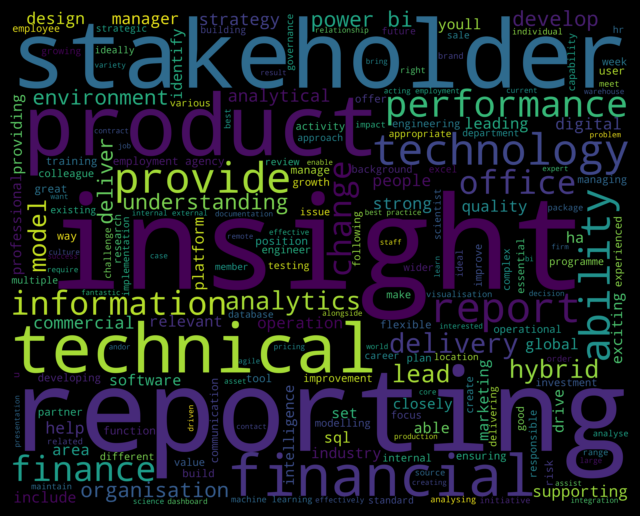

In [71]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

# Add words that frequently appear in the descriptions but carry no value
from sklearn.feature_extraction import text
extra_stopword = ['data','business','experience','team','role','working','work','analyst','skill','skills','opportunity','support','management','process','project','client','company','within','customer','requirement','required','including','successful','candidate','looking','uk','apply','analysis','analytic','solution','knowledge','need','ensure','key','new','using','application','graduate','qualification','junior','senior','banking','group','level','day','join','based','time','use','understand','benefit','year','market','excellent','development','london','responsibility','service','will']
exstopwords = text.ENGLISH_STOP_WORDS.union(extra_stopword)

text = " ".join(datajobs['descriptionclean'])

wc = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = exstopwords, 
                    min_font_size = 10).generate(text)


plt.figure(figsize = (8, 8), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

### Visualizing Data Analyst Salaries

In [76]:
datajobs.isna().sum()

title                 0
company               0
salary_type           0
salary_min          308
salary_max          308
annual_salary       308
city                  0
region                0
remote                0
status1               0
status2               0
descriptionclean      0
dtype: int64

In [77]:
# drop columns with no salary for salary analysis
datajobs_ws = datajobs.dropna().reset_index(drop=True)

In [78]:
datajobs_ws.shape

(1107, 12)

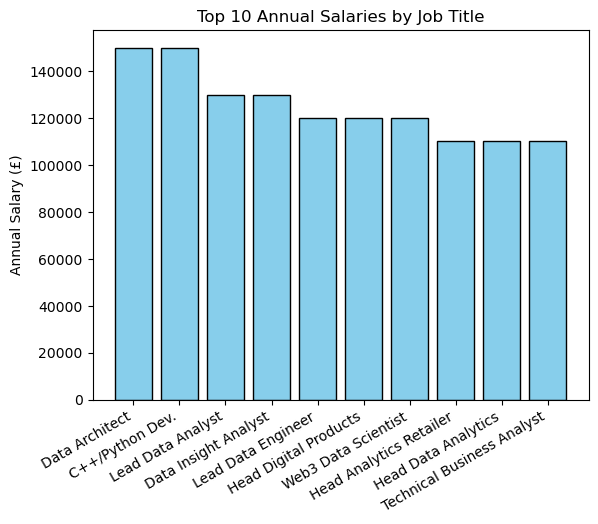

In [80]:
# sort the dataframe by annual salary in descending order and select top
annual_salaries = datajobs_ws[datajobs_ws['salary_type'] == 'annual']
annual_salaries = annual_salaries.sort_values(by='salary_max', ascending=False)
topjobs = annual_salaries.iloc[:10]

# create a bar plot for the top 10 job titles by annual salary
plt.bar(topjobs['title'], topjobs['salary_max'], color='skyblue', edgecolor='black')

# set the title and axis labels for the plot
plt.title('Top 10 Annual Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

# rotate the x-axis labels for better readability
plt.xticks(rotation=30, ha='right')

#set new tick labels for the x-axis
new_xtick_labels = ['Data Architect','C++/Python Dev.','Lead Data Analyst','Data Insight Analyst','Lead Data Engineer','Head Digital Products','Web3 Data Scientist', 'Head Analytics Retailer', 'Head Data Analytics', 'Technical Business Analyst']
plt.xticks(range(len(topjobs)), new_xtick_labels)

# display the plot
plt.show()


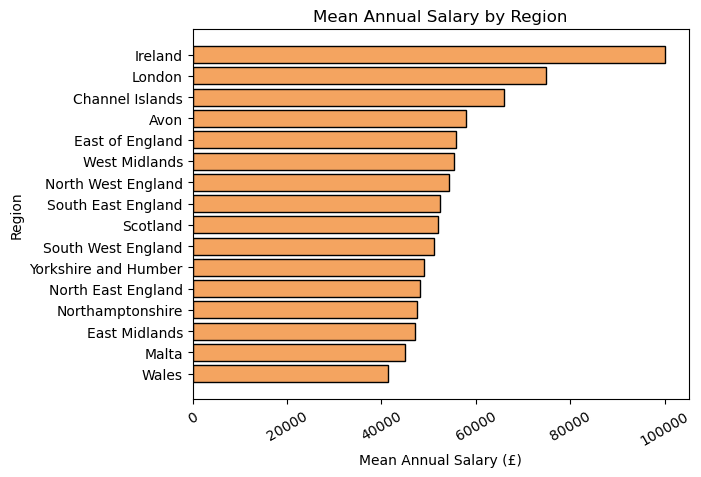

In [81]:
# group the data by region and calculate the mean annual salary
d1 = datajobs_ws.groupby(['region']).agg({'annual_salary': np.mean})
d1 = d1.sort_values(by='annual_salary', ascending=False)

# bar plot of the mean annual salary by region
plt.barh(d1.index, d1['annual_salary'], color='sandybrown', edgecolor='black')

# set the title and labels for the plot
plt.gca().invert_yaxis()
plt.title('Mean Annual Salary by Region')
plt.xlabel('Mean Annual Salary (£)')
plt.ylabel('Region')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=30)

# show the plot
plt.show()

### Visualizing Junior and Senior roles

In [65]:
#Select Data Analyst postings from the listings
juniorroles = datajobs[datajobs['title'].str.lower().str.contains("junior|graduate|apprentice|entry level|entrylevel")]
seniorroles = datajobs[datajobs['title'].str.lower().str.contains("senior|lead|head|vp")]

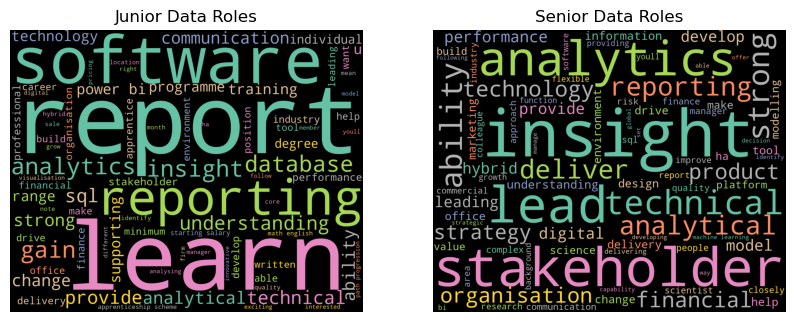

In [72]:
# generate word clouds for junior and senior roles
junior_wc = WordCloud(background_color='black', colormap='Set2', random_state=1, stopwords=exstopwords, max_words=80, width=1500, height=1200).generate(' '.join(juniorroles['descriptionclean']))
senior_wc = WordCloud(background_color='black', colormap='Set2', random_state=1, stopwords=exstopwords, max_words=80, width=1500, height=1200).generate(' '.join(seniorroles['descriptionclean']))

# create a figure with two subplots for the word clouds
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# set the title for the subplots
axs[0].set_title('Junior Data Roles')
axs[1].set_title('Senior Data Roles')

# display the word clouds in the subplots
axs[0].imshow(junior_wc)
axs[1].imshow(senior_wc)

# remove the axis labels from the subplots
axs[0].axis('off')
axs[1].axis('off')

# display the figure
plt.show()


In [73]:
# Check the mean salary for junior and senior roles
junior_mean_salary = juniorroles['annual_salary'].mean()
senior_mean_salary = seniorroles['annual_salary'].mean()

print("Mean annual salary for junior roles:", junior_mean_salary)
print("Mean annual salary for senior roles:", senior_mean_salary)

Mean annual salary for junior roles: 33529.096153846156
Mean annual salary for senior roles: 70990.48792270532


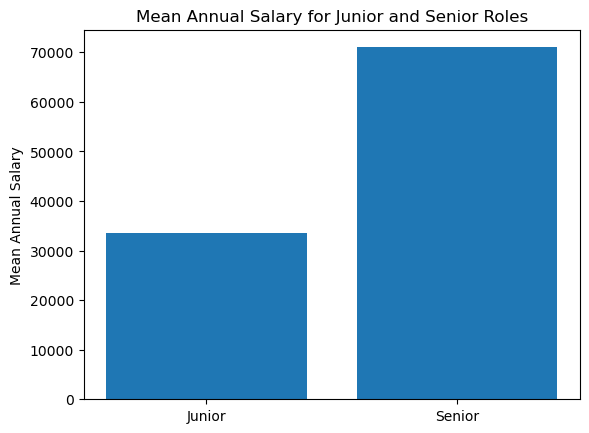

In [74]:
# Plotting the mean salaries
fig, ax = plt.subplots()
ax.bar(['Junior', 'Senior'], [junior_mean_salary, senior_mean_salary])
ax.set_ylabel('Mean Annual Salary')
ax.set_title('Mean Annual Salary for Junior and Senior Roles')
plt.show()

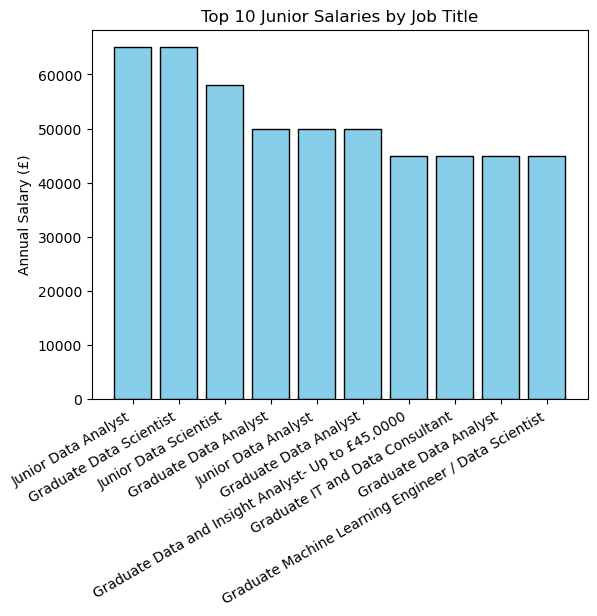

In [75]:
# sort the dataframe by annual salary in descending order and select top
juniorroles_salaries = juniorroles[juniorroles['salary_type'] == 'annual']
topjuniorjobs = juniorroles_salaries.sort_values(by='salary_max', ascending=False)
topjuniorjobs = topjuniorjobs.iloc[:10]

# add random jitter to x-axis positions
jitter = np.random.normal(scale=0, size=len(topjuniorjobs))
x = np.arange(len(topjuniorjobs)) + jitter

# create a bar plot for the top 10 job titles by annual salary
plt.bar(x, topjuniorjobs['salary_max'], color='skyblue', edgecolor='black')

# set the x-axis tick labels to the job titles
plt.xticks(x, topjuniorjobs['title'], rotation=30, ha='right')

# set the title and axis labels for the plot
plt.title('Top 10 Junior Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

#set new tick labels for the x-axis
#new_xtick_labels = ['Junior Data Analyst', 'Graduate Data Scientist','Junior Data Scientist', 'Graduate Data Analyst', 'Junior Data Analyst', 'Graduate Data Analyst', 'Graduate Data Insight Analyst', 'Graduate IT Data Consultant', 'Graduate Data Analyst', 'Graduate ML Engineer']
#plt.xticks(range(len(topjobs)), new_xtick_labels)

plt.show()

### Visualizing remote roles

In [82]:
remoteroles_ns = datajobs[datajobs['remote']=='yes']
remoteroles_ws = datajobs_ws[datajobs_ws['remote']=='yes']

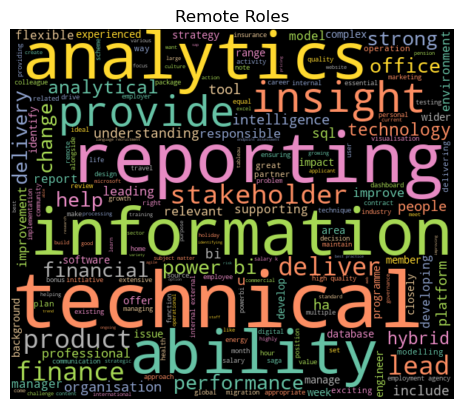

In [83]:
#word cloud
text = " ".join(remoteroles_ns['descriptionclean'])

wc= WordCloud(random_state=1,background_color='black', colormap='Set2', stopwords=exstopwords, width =600, height = 500)
wc.generate(text)

fig, axs = plt.subplots()
axs.imshow(wc, interpolation="bilinear")
axs.axis('off')

# set the title of the axes
axs.set_title("Remote Roles")
plt.show()

In [84]:
# Check the mean salary for remote roles
remote_mean_salary = remoteroles_ns['annual_salary'].mean()
print("Mean annual salary for remote roles:", remote_mean_salary)

Mean annual salary for remote roles: 62367.232323232325


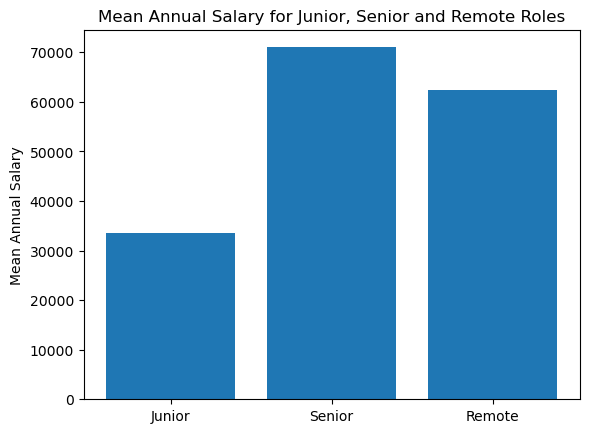

In [85]:
# Compare with junior and senior roles and plot the mean salaries
fig, ax = plt.subplots()
ax.bar(['Junior', 'Senior', 'Remote'], [junior_mean_salary,senior_mean_salary,remote_mean_salary])
ax.set_ylabel('Mean Annual Salary')
ax.set_title('Mean Annual Salary for Junior, Senior and Remote Roles')
plt.show()

What can this tell us about remote roles? Could this mean that they are mostly for senior analysts?

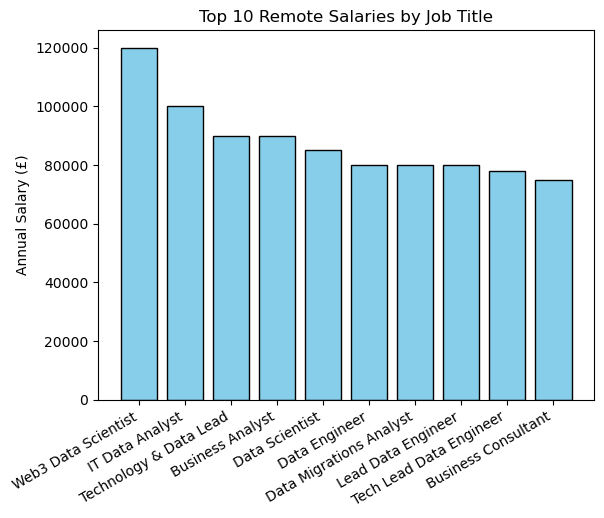

In [87]:
# sort the dataframe by annual salary in descending order and select top remote salaries
remote_salaries = remoteroles_ws[remoteroles_ws['salary_type'] == 'annual']
topremotejobs = remote_salaries.sort_values(by='salary_max', ascending=False)
topremotejobs = topremotejobs[:10]

# create a bar plot for the top 10 job titles by annual salary
plt.bar(topremotejobs['title'], topremotejobs['annual_salary'], color='skyblue', edgecolor='black')

# set the title and axis labels for the plot
plt.title('Top 10 Remote Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

# rotate the x-axis labels for better readability
plt.xticks(rotation=30, ha='right')

#set new tick labels for the x-axis
new_xtick_labels = ['Web3 Data Scientist','IT Data Analyst','Technology & Data Lead','Business Analyst','Data Scientist', 'Data Engineer', 'Data Migrations Analyst', 'Lead Data Engineer', 'Tech Lead Data Engineer','Business Consultant']
plt.xticks(range(len(topjobs)), new_xtick_labels)

# display the plot
plt.show()


# Modeling

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
import seaborn as sns

In [159]:
datajobs_ws.shape

(1107, 13)

#### Lets create a new target where annual salary is either high or low

In [160]:
# get the 60th percentile value of salary
sal60 = np.percentile(datajobs_ws['annual_salary'], 60)

In [161]:
# make a new target variable that captures whether salary is high (1) or low (0)
datajobs_ws['salary_target'] = np.where(datajobs_ws['annual_salary'] >= sal60, 1, 0)

In [162]:
datajobs_ws.salary_target.value_counts()

0    629
1    478
Name: salary_target, dtype: int64

In [163]:
datajobs_ws.salary_target.value_counts()/len(datajobs_ws)

0    0.568202
1    0.431798
Name: salary_target, dtype: float64

In [164]:
#get X and Y
X = datajobs_ws['descriptionclean']
y = datajobs_ws['salary_target']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [165]:
# transform X_train and X_test variables into numerical feature vectors of token counts
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

#### MultinomialNB Model

In [166]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train_counts, y_train)

MultinomialNB()

In [167]:
# Evaluate the model
y_pred1 = mnb_model.predict(X_test_counts)
accuracy = mnb_model.score(X_test_counts, y_test)
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy, precision, recall, f1))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, y_pred1))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred1))

Accuracy: 0.81, Precision: 0.87, Recall: 0.67, F1 Score: 0.76
Area under the ROC curve: 0.7971230158730159
Model Confusion Matrix:
 [[174  15]
 [ 47  97]]


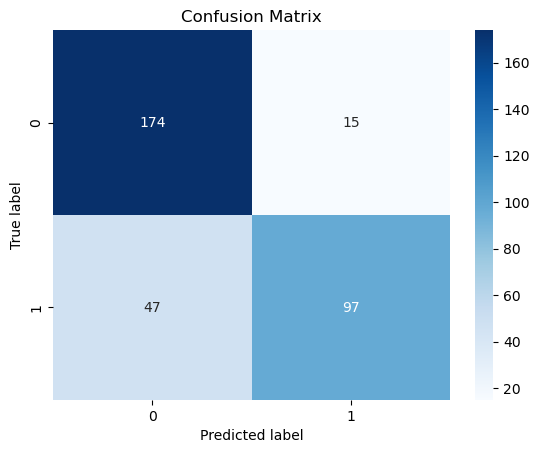

In [168]:
# create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred1)

# create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# set labels for the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# display the plot
plt.show()

#### Logistic Regression Model

In [169]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_counts, y_train)

LogisticRegression(max_iter=1000)

In [170]:
# Evaluate the model
y_pred2 = logreg.predict(X_test_counts)
accuracy = logreg.score(X_test_counts, y_test)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy, precision, recall, f1))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, y_pred2))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred2))

Accuracy: 0.78, Precision: 0.76, Recall: 0.73, F1 Score: 0.74
Area under the ROC curve: 0.7746362433862434
Model Confusion Matrix:
 [[155  34]
 [ 39 105]]


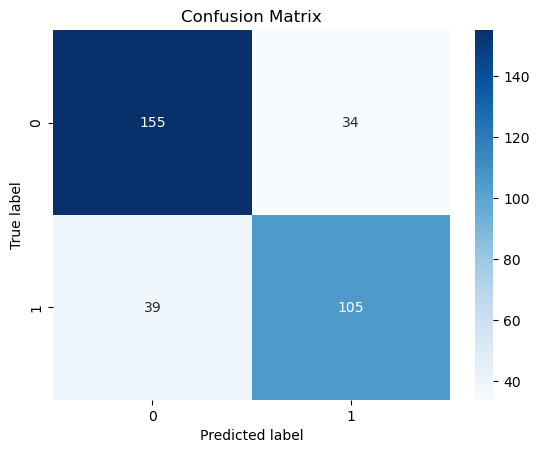

In [171]:
# create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred2)

# create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# set labels for the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# display the plot
plt.show()

### Job Search Filter

In [172]:
df.to_csv('streamlit.csv', index=False)

In [ ]:
#Filter 1 = Junior jobs
#Filter 2 = Senior roles
#Filter 3 = Remote roles
#Filter 4 = Contract Jobs

In [175]:
def search_jobs():
    # Load the job DataFrame
    df_jobs = df
    
    # Get user input for keywords
    junior = input("Filter by junior jobs? (y/n) ").lower() == 'y'
    senior = input("Filter by senior jobs? (y/n) ").lower() == 'y'
    remote = input("Filter by remote jobs? (y/n) ").lower() == 'y'
    contract = input("Filter by contract jobs? (y/n) ").lower() == 'y'

    
    # Filter the DataFrame based on the input keywords
    if contract:
        df_jobs = df_jobs[df_jobs['status1'] == 'Contract']
    if remote:
        df_jobs = df_jobs[df_jobs['remote'] == 'yes']
    if junior:
        df_jobs = df_jobs[df_jobs['title'].str.lower().str.contains("junior|graduate|apprentice|entry level")]
    if senior:
        df_jobs = df_jobs[df_jobs['title'].str.lower().str.contains("senior|lead|head|vp")]
    
    # format salary and link
    df_jobs['annual_salary £'] = df_jobs['annual_salary'].fillna('negotiable').apply(lambda x: '{:.0f}'.format(x) if isinstance(x, float) else x)
    df_jobs['link'] = df_jobs['link'].apply(lambda x:'<a href="{0}" target="_blank">link</a>'.format(x))
    df_jobs = df_jobs.reset_index(drop=True)    
    
    # Return the filtered jobs
    print(f"{len(df_jobs)} job(s) found.")
    return df_jobs[['title', 'region', 'status1', 'salary', 'link']].style.format({'link': lambda x: x if x.startswith('<a') else '<a>{}</a>'.format(x)})


In [176]:
pd.reset_option('display.max_colwidth')
search_jobs()

Filter by junior jobs? (y/n) y
Filter by senior jobs? (y/n) n
Filter by remote jobs? (y/n) y
Filter by contract jobs? (y/n) n
4 job(s) found.


,title,region,status1,salary,link
0,Junior Data Analyst,South West England,Permanent,"£26,000 - £28,000 per annum",link
1,Data Analyst Apprenticeship,South East England,Permanent,Competitive salary,link
2,Data Analyst Apprenticeship,South East England,Permanent,Competitive salary,link
3,Data Analyst Apprenticeship - Clone Record,South East England,Permanent,Competitive salary,link
